In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [8]:
# set theme
plt.style.use('seaborn')
sns.set_style('darkgrid')

In [9]:
prices = pd.read_csv('vbr18_21.csv', index_col=0)
prices = prices.dropna(axis=1)
returns = np.log(prices).diff().dropna()

In [10]:
form_start = '2018-11-20'
form_end = '2020-05-19'
trade_start = '2021-05-20'
trade_end = '2021-11-19'

prices_form = prices[form_start:form_end]
prices_trade = prices[trade_start:trade_end]
returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]

In [5]:
'''
# Calculate Kendall's tau for each pair of stocks
results = pd.DataFrame(columns=['tau'])

for s1 in returns_form.columns:
    for s2 in returns_form.columns:
        if (s1!=s2) and (f'{s2}-{s1}' not in results.index):
            results.loc[f'{s1}-{s2}'] = stats.kendalltau(returns_form[s1], returns_form[s2])[0]
'''

"\n# Calculate Kendall's tau for each pair of stocks\nresults = pd.DataFrame(columns=['tau'])\n\nfor s1 in returns_form.columns:\n    for s2 in returns_form.columns:\n        if (s1!=s2) and (f'{s2}-{s1}' not in results.index):\n            results.loc[f'{s1}-{s2}'] = stats.kendalltau(returns_form[s1], returns_form[s2])[0]\n"

In [6]:
#results.to_csv('pairs_tau.csv')

In [7]:
results = pd.read_csv('pairs_tau.csv', index_col=0)

In [8]:
results.sort_values(by='tau')

,tau
WTRG-SWN,-0.054499
FLO-SWN,-0.050804
OVV-FLO,-0.045919
FLO-AR,-0.045274
BGS-WK,-0.041691
...,...
HOMB-CATY,0.725432
CFR-ASB,0.729228
CFR-BOKF,0.731751
MTG-RDN,0.738985


In [9]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

In [10]:
selected_stocks = []
selected_pairs = []

for pair in results.sort_values(by='tau', ascending=False).index:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_stocks.append(s1)
        selected_stocks.append(s2)
        selected_pairs.append(pair)
    
    if len(selected_pairs) == 25:
        break

In [11]:
print(selected_pairs)

['CENTA-CENT', 'MTG-RDN', 'CFR-BOKF', 'HOMB-CATY', 'CMA-ZION', 'EWBC-ASB', 'UMBF-FULT', 'TDS-USM', 'KIM-BRX', 'PACW-FNB', 'NBTB-STBA', 'VOYA-LNC', 'VLY-HOPE', 'ONB-FFBC', 'COLB-FCF', 'ROIC-AKR', 'UBSI-TRMK', 'FRME-HTLF', 'WAL-UMPQ', 'STL-HWC', 'FR-EGP', 'GBCI-FIBK', 'PBCT-WBS', 'AWR-CWT', 'AUB-TOWN']


# Fit marginals

In [12]:
marginals_df = pd.DataFrame(index=selected_stocks, columns=['Distribution', 'AIC', 'BIC', 'KS_pvalue'])

for stock in selected_stocks:
    data = returns_form[stock]
    dists = ['Normal', "Student's t", 'Logistic', 'Extreme']
    best_aic = np.inf
    for dist,name in zip([stats.norm, stats.t, stats.genlogistic, stats.genextreme], dists):
        params = dist.fit(data)
        dist_fit = dist(*params)
        log_like = np.log(dist_fit.pdf(data)).sum()
        aic = 2*len(params) - 2 * log_like
        if aic<best_aic:
            best_dist = name
            best_aic = aic
            best_bic = len(params) * np.log(len(data)) - 2 * log_like
            ks_pval = stats.kstest(data, dist_fit.cdf, N=100)[1]
    marginals_df.loc[stock] = [best_dist, best_aic, best_bic, ks_pval]

/home/alex/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


In [13]:
marginals_df.head(10)

,Distribution,AIC,BIC,KS_pvalue
CENTA,Student's t,-1766.721394,-1754.948627,0.501764
CENT,Student's t,-1776.277334,-1764.504567,0.788573
MTG,Student's t,-1705.88267,-1694.109902,0.648663
RDN,Student's t,-1721.424509,-1709.651741,0.739781
CFR,Student's t,-1733.045019,-1721.272252,0.864011
BOKF,Student's t,-1749.361441,-1737.588673,0.871464
HOMB,Student's t,-1659.902646,-1648.129878,0.957393
CATY,Student's t,-1783.08619,-1771.313422,0.990013
CMA,Student's t,-1650.420255,-1638.647488,0.421582
ZION,Student's t,-1799.031782,-1787.259015,0.494674


In [14]:
marginals_df['Distribution'].unique()

array(["Student's t"], dtype=object)

In [15]:
marginals_df[marginals_df['KS_pvalue'] < 0.05]

,Distribution,AIC,BIC,KS_pvalue


# Fit copulas

In [16]:
from copulas import *
import ndtest # bivariate Kolmogorov-Smirnov

In [17]:
copulas_df = pd.DataFrame(index=selected_pairs, columns=['copula', 'parameter', 'aic', 'bic', 'KS_pvalue'])

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    # fit marginals
    params_s1 = stats.t.fit(returns_form[s1])
    dist_s1 = stats.t(*params_s1)
    params_s2 = stats.t.fit(returns_form[s2])
    dist_s2 = stats.t(*params_s2)
    # apply probability integral transform
    u = dist_s1.cdf(returns_form[s1])
    v = dist_s2.cdf(returns_form[s2])
    
    best_aic = np.inf
    
    for copula in [GaussianCopula(), ClaytonCopula(), GumbelCopula(), FrankCopula(), JoeCopula()]:
        copula.fit(u,v)
        L = copula.log_likelihood(u,v)
        aic = 2 * copula.num_params - 2 * L
        if aic < best_aic:
            best_aic = aic
            best_bic = copula.num_params * np.log(len(u)) - 2 * L
            best_copula = copula.name
            
            # calculate KS-pvalue
            smp = copula.sample(size=len(u)) # generate sample from fit copula
            s_u = smp[:,0]
            s_v = smp[:,1]
            ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)
            
            if isinstance(copula, ArchimedeanCopula):
                best_param = copula.alpha
            else:
                best_param = copula.rho
            
    copulas_df.loc[pair] = [best_copula, best_param, best_aic, best_bic, ks_pval]

/home/alex/work/blog/pairs_trading/copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()


In [18]:
copulas_df.head(10)

,copula,parameter,aic,bic,KS_pvalue
CENTA-CENT,Gaussian,0.966486,-1016.713382,-1012.789126,0.66109
MTG-RDN,Gumbel,3.992679,-718.431293,-714.507038,0.524949
CFR-BOKF,Gaussian,0.912532,-676.586878,-672.662623,0.361025
HOMB-CATY,Gumbel,3.690078,-663.407379,-659.483123,0.405205
CMA-ZION,Gaussian,0.90773,-658.74903,-654.824774,0.359609
EWBC-ASB,Gaussian,0.899782,-631.174724,-627.250468,0.317748
UMBF-FULT,Gumbel,3.570006,-638.695131,-634.770875,0.119134
TDS-USM,Gaussian,0.893793,-612.089583,-608.165327,0.307185
KIM-BRX,Gumbel,3.48765,-621.368826,-617.44457,0.085422
PACW-FNB,Gaussian,0.892387,-607.811515,-603.88726,0.217961


In [19]:
copulas_df['copula'].unique()

array(['Gaussian', 'Gumbel'], dtype=object)

In [20]:
copulas_df[copulas_df['KS_pvalue']<0.05]

,copula,parameter,aic,bic,KS_pvalue


In [21]:
algo_returns = {}
cl = 0.99 # confidence level

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)

    # fit marginals
    params_s1 = stats.t.fit(returns_form[s1])
    dist_s1 = stats.t(*params_s1)
    params_s2 = stats.t.fit(returns_form[s2])
    dist_s2 = stats.t(*params_s2)

    # transform marginals
    u = dist_s1.cdf(returns_form[s1])
    v = dist_s2.cdf(returns_form[s2])
        
    # fit copula
    best_aic = np.inf
    best_copula = None

    copulas = [GaussianCopula(), ClaytonCopula(), GumbelCopula(), FrankCopula(), JoeCopula()]
    for copula in copulas:
        copula.fit(u,v)
        L = copula.log_likelihood(u,v)
        aic = 2 * copula.num_params - 2 * L
        if aic < best_aic:
            best_aic = aic
            best_copula = copula
            
    # calculate conditional probabilities
    prob_s1 = []
    prob_s2 = []

    for u,v in zip(dist_s1.cdf(returns_trade[s1]), dist_s2.cdf(returns_trade[s2])):
        prob_s1.append(best_copula.cdf_u_given_v(u,v))
        prob_s2.append(best_copula.cdf_v_given_u(u,v))
        
    probs_trade = pd.DataFrame(np.vstack([prob_s1, prob_s2]).T, index=returns_trade.index, columns=[s1, s2])
    
    # calculate positions
    positions = pd.DataFrame(index=probs_trade.index, columns=probs_trade.columns)
    long = False
    short = False

    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][s1] > 0.5) or (probs_trade.loc[t][s2] < 0.5):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][s1] < 0.5) or (probs_trade.loc[t][s2] > 0.5):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][s1] < (1-cl)) and (probs_trade.loc[t][s2] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][s1] > cl) and (probs_trade.loc[t][s2] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]
                
    # calculate returns
    algo_ret = (returns_trade * positions.shift()).sum(axis=1)
    algo_returns[pair] = algo_ret

/home/alex/work/blog/pairs_trading/copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()


In [22]:
returns = pd.DataFrame.from_dict(algo_returns)
returns = np.exp(returns) - 1 # convert log-returns to simple returns

In [23]:
total_ret = returns.sum(axis=1) / len(returns.columns) * 2 # double capital (from short positions)

In [24]:
import yfinance as yf
vbr_price = yf.download('VBR', start=trade_start, end=trade_end)
vbr_price = vbr_price['Adj Close']
vbr_ret = vbr_price.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


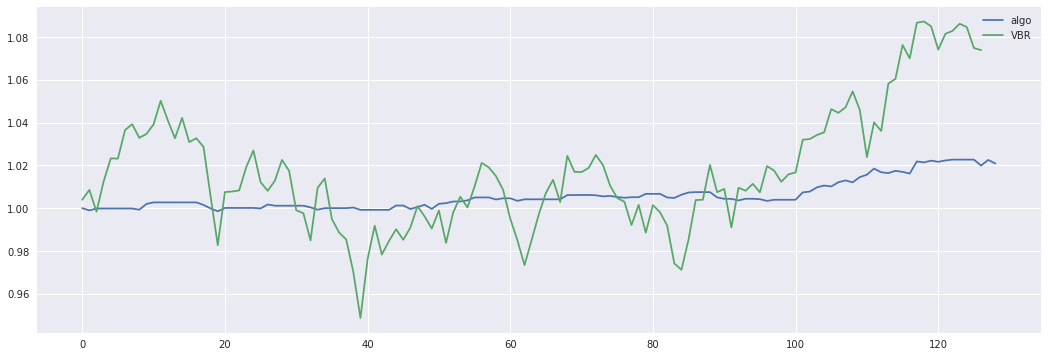

In [28]:
plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(total_ret + 1), label='algo')
plt.plot(np.nancumprod(vbr_ret + 1), label='VBR')
plt.legend()

In [33]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [42]:
metrics = pd.DataFrame(index=['Algo', 'VBR'], columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])
metrics.loc['Algo'] = calculate_metrics(np.nancumprod(total_ret + 1))
metrics.loc['VBR'] = calculate_metrics(np.nancumprod(vbr_ret + 1))
metrics

,Total return,APR,Sharpe,MaxDD,MaxDDD
Algo,0.0209,0.041235,2.310103,-0.004165,35.0
VBR,0.069689,0.143021,0.867726,-0.096744,96.0


# Exit earlier

In [53]:
algo_returns = {}
cl = 0.99 # confidence level

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)

    # fit marginals
    params_s1 = stats.t.fit(returns_form[s1])
    dist_s1 = stats.t(*params_s1)
    params_s2 = stats.t.fit(returns_form[s2])
    dist_s2 = stats.t(*params_s2)

    # transform marginals
    u = dist_s1.cdf(returns_form[s1])
    v = dist_s2.cdf(returns_form[s2])
        
    # fit copula
    best_aic = np.inf
    best_copula = None

    copulas = [GaussianCopula(), ClaytonCopula(), GumbelCopula(), FrankCopula(), JoeCopula()]
    for copula in copulas:
        copula.fit(u,v)
        L = copula.log_likelihood(u,v)
        aic = 2 * copula.num_params - 2 * L
        if aic < best_aic:
            best_aic = aic
            best_copula = copula
            
    # calculate conditional probabilities
    prob_s1 = []
    prob_s2 = []

    for u,v in zip(dist_s1.cdf(returns_trade[s1]), dist_s2.cdf(returns_trade[s2])):
        prob_s1.append(best_copula.cdf_u_given_v(u,v))
        prob_s2.append(best_copula.cdf_v_given_u(u,v))
        
    probs_trade = pd.DataFrame(np.vstack([prob_s1, prob_s2]).T, index=returns_trade.index, columns=[s1, s2])
    
    # calculate positions
    positions = pd.DataFrame(index=probs_trade.index, columns=probs_trade.columns)
    long = False
    short = False

    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][s1] > 0.3) or (probs_trade.loc[t][s2] < 0.7):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][s1] < 0.7) or (probs_trade.loc[t][s2] > 0.3):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][s1] < (1-cl)) and (probs_trade.loc[t][s2] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][s1] > cl) and (probs_trade.loc[t][s2] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]
                
    # calculate returns
    algo_ret = (returns_trade * positions.shift()).sum(axis=1)
    algo_returns[pair] = algo_ret

/home/alex/work/blog/pairs_trading/copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()


In [54]:
returns = pd.DataFrame.from_dict(algo_returns)
returns = np.exp(returns) - 1 # convert log-returns to simple returns

In [55]:
total_ret = returns.sum(axis=1) / len(returns.columns) * 2 # double capital (from short positions)

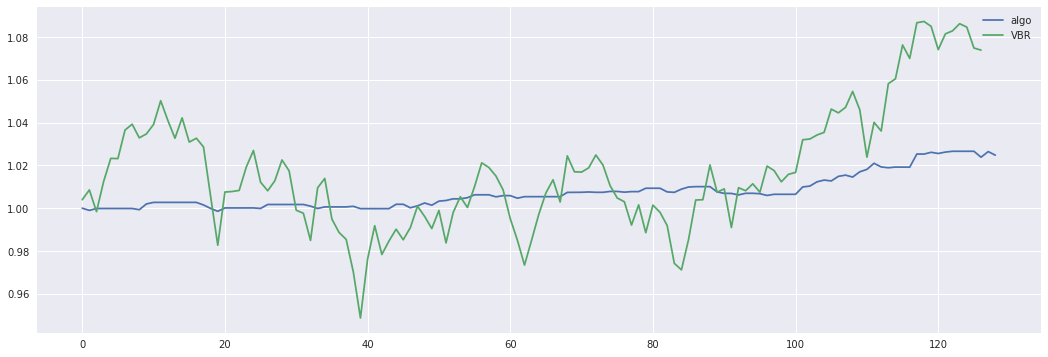

In [56]:
plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(total_ret + 1), label='algo')
plt.plot(np.nancumprod(vbr_ret + 1), label='VBR')
plt.legend()

In [57]:
metrics = pd.DataFrame(index=['Algo', 'VBR'], columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])
metrics.loc['Algo'] = calculate_metrics(np.nancumprod(total_ret + 1))
metrics.loc['VBR'] = calculate_metrics(np.nancumprod(vbr_ret + 1))
metrics

,Total return,APR,Sharpe,MaxDD,MaxDDD
Algo,0.024795,0.049009,2.75403,-0.004165,33.0
VBR,0.069689,0.143021,0.867726,-0.096744,96.0
